# Model-building phase: water50
- [Data Preprocessing](#data-preprocessing)
- [Supervised Models](#supervised-models)
    - [Random Forest](#random-forest)
    - [Gradient Boosting](#gradient-boosting)
    - [SVM](#support-vector-machines-svm)
    - [Model Evaluation](#models-evaluation)
- [Unsupervised Models](#unsupervised-models)
    - [PCA](#principal-component-analysis)
    - [SVD](#truncated-svd)
    - [K-Means](#k-means)
    - [DBSCAN](#dbscan)
- [Conclusion](#conclusion)


In [25]:
import pandas as pd
import numpy as np
import random
from tools import *
from pprint import pprint
import pickle
import seaborn as sns
import matplotlib.colors as mcolors

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from  sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA, TruncatedSVD

## Data Preprocessing 

In preprocessing the data we make use of the *prep* function, which simultaneously allows us both to deal with the missing values, giving us the choice of removing them, or partially removing them by replacing the remainder with the mean or median of the corresponding variable, and to scale the data, with the possibility of choosing the method by which to scale such data from all the scalers in scikit-learn, by default the MinMaxScaler is set. The function then takes as input a pandas DataFrame and outputs a numpy ndarray containing the cleaned data from the previous dataset.

Our idea is to generate two datasets: the first by eliminating all observations having at least one component with a missing value, the second by eliminating only 50 percent of those observations. Eventually we will train each model using both datasets and collect their metrics in order to assess whether on average such a reduction in missing values to be eliminated (thus replacing the missing part) resulted in any benefit.

### Scaling Data
To observe if there are difference in performance of the models  trained on a dataset with  all the Nan values imputed and in the models trained on a dataset with only a percentage of Nan values imputed, we have  created 2 dataset:
- one where we imputed all the Nan values (Water 100 dataset)
- one where we imputed only the half Nan values deleting the remain part of observations (Water 50 dataset)

In this notebook we will analyze and attempt to build a model using the data set in which 50 percent of the missing observations were filled in by the mean value of the respective class of the target variable to which they belong.

In [26]:
random_seed = 42

In [27]:
# Setting random state for each model
water = pd.read_csv('dataset/drinking_water_potability.csv')
water50 = prep(
    data = water,
    target='Potability',
    axis='obs',
    perc=50,
    fill_method='mean',
    scaler= StandardScaler(),
    random_state = random_seed
)

print('original dataset size: ', water.shape, '- type: ', type(water))
print('cleaned dataset with 50% of missing values removed: ', np.shape(water50), '- type: ', type(water50))

original dataset size:  (3276, 10) - type:  <class 'pandas.core.frame.DataFrame'>
cleaned dataset with 50% of missing values removed:  (2644, 10) - type:  <class 'numpy.ndarray'>


### Splitting Data
We now proceed to split the dataset into train set and test set. To do this, we make use of another function contained in the *tools* module: the *split* function. We decided to write this function to allow us to split the dataset into train, validation and test set in one go by specifying the index for the target variable. To split the dataset, this function leverages the *train_test_split()* function of *scikit-learn()*.

In [4]:
X_train50, X_test50, y_train50, y_test50=split(df = water50, target_index = 9, perc_train = 0.7, random_seed = random_seed, verbose=True, validation=False)


BEFORE SPLITTING: 

X shape:  (2644, 9)
y shape:  (2644,)

AFTER SPLITTING: 
X_train shape:  (1850, 9)
y_train shape:  (1850,)
X_test shape:  (794, 9)
y_test shape:  (794,)


In performing its task, the *split()* function of the *tools* module initially counts the number of observations that contain at least one component having a missing value. Of these observations, the function randomly chooses a number equal to half of this value and replaces them with a statistically significant value, while the remainder will be dropped. 

This could lead to an imbalance in the dataset. To prevent this, we now plot the total number of observations by target class.

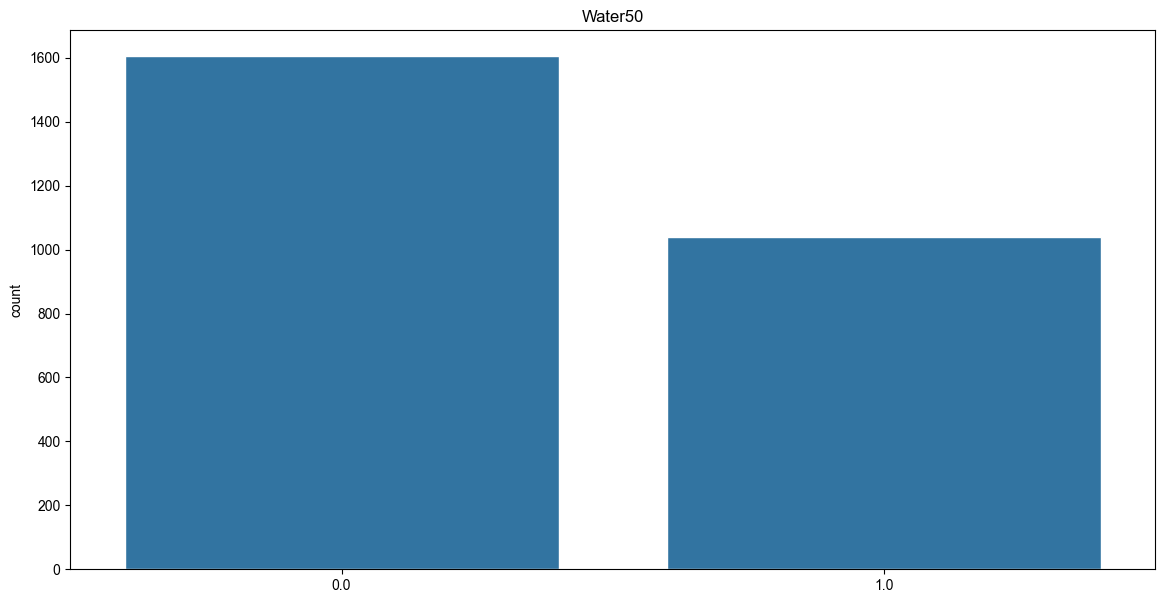

Water100 Unbalancing:
- Class 0 / Class1: 0.61% / 0.39%



In [5]:
# Checking Data Unbalncing w/ Count Plot

plt.subplots(figsize=(14,7))
sns.set_style("whitegrid")
w50 = water50[:,9]
colors = list(mcolors.TABLEAU_COLORS.values())

fig =sns.countplot(x=w50, color =colors[0])
fig.set_title('Water50')
plt.show()

print('Water100 Unbalancing:\n- Class 0 / Class1: {:0.2f}% / {:0.2f}%\n'.format(w50[np.where(w50==0)].size/w50.size,w50[np.where(w50==1)].size/w50.size))

As we can see from the graph, the presence, in terms of percentage, of observations belonging to each class reflects that of the initial dataset. Thus we can say that no imbalance problem occurred.

## Supervised Models
The Supervised models that we chose are the following:
- **Random Forest**
- **XGBoost**
- **Support Vector Machine**
- **K-Nearest Neighbours**

### **Random Forest**

Random forest or random decision forest is an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees. 

Source: [link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)



In [18]:
# Training base model
rf_base_w50 = RandomForestClassifier(random_state = random_seed)
rf_base_w50.fit(X_train50, y_train50)

#Computing the base model accuracy
rf_base_metrics_w50 = evaluate(rf_base_w50, X_train50, y_train50,cv=True,k_fold=5)

Model Performance: 

accuracy = 73.24%.
recall = 52.05%.
precision = 72.56%.
f1_score = 60.57%.


#### Random Search w/ Cross Validation
 First of all we will start searching the best configuration of hyperparameters with a random search choosing among 
 thousand combinations of hyperparameters 100 random combinations, after this first step we will focus more with a grid 
search around the best combinations found with the random search

In [19]:
#Defining Random Forest Claasifier
rf = RandomForestClassifier(random_state = random_seed)
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
rf.get_params()

Parameters currently in use:



{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


As we can see there are many hyperparameter that we can tune, but for the moment we will focus more only on  the most importants

In [8]:
random_grid = {
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 500, num = 10)], # Number of trees in random forest
    'max_features': [ 'sqrt','log2', None],                                           # Number of features to consider at every split
    'max_depth': [int(x) for x in np.linspace(10, 30, num = 11)] + [None],            # Maximum number of levels in tree
    'min_samples_split': [2, 5, 10],                                                  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],                                                    # Minimum number of samples required at each leaf node
    'bootstrap': [True, False],                                                       # Method of selecting samples for training each tree
    'criterion':['gini', 'entropy', 'log_loss']                                       # Metrics  to measure the quality of a split.
}

rf_random_search_w50 = RandomizedSearchCV(
    estimator = rf, 
    param_distributions = random_grid,
    n_iter = 100, 
    cv = 3, 
    random_state=random_seed, 
    n_jobs = -1
    )

rf_random_search_w50.fit(X_train50, y_train50)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [10, 12, 14, 16, 18, 20,
                                                      22, 24, 26, 28, 30,
                                                      None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 233, 266, 300,
                                                         333, 366, 400, 433,
                                                         466, 500]},
                   random_state=42)

Actually if we used all the possible combinations we should train the random forest 25920 times without considering the cross validation for each combinations, that would require a computational time too high, for this reason initially we will use the random search using only 100 random combinations among those available

##### Store and Load Models
To avoid  traininig each time the models we will save after every training of the models the results inside *Models folder* using pickle library


In [15]:
#pickle.dump(rf_random_search.best_params_, open('Models50/Random_Forest_rs_w50.pkl', 'wb'))
rf_params_search_w50=pickle.load(open('Models50/Random_Forest_rs_w50.pkl', 'rb'))
rf_params_search_w50

{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 24,
 'criterion': 'gini',
 'bootstrap': True}

##### Comparing base model with tuned model with Random Search
To check if we are going in right direction we will compare the base model without tuning of parameters with the tuned model comparing the accuracy of both models on validation set

In [16]:
# Training tuned model
rf_random_w50 =  RandomForestClassifier(
    bootstrap = True,
    criterion='gini',
    max_depth=24,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=500,
    random_state=random_seed)


In [20]:
#Computing the tuned model's metrics                                 
rf_random_metrics_w50 = evaluate(rf_random_w50, X_train50, y_train50,cv=True)

improvements(rf_random_metrics_w50,rf_base_metrics_w50,'Tuned','Base Model')

Model Performance: 

accuracy = 73.30%.
recall = 52.73%.
precision = 72.22%.
f1_score = 60.89%.

Improvements Tuned Model respect Base Model:
Accuracy: 0.07 %
Recall: 1.32 %
Precision: -0.47 %
F1-Score: 0.53 %


#### Grid Search w/ Cross Validation
Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define. To use Grid Search, we make another grid based on the best values provided by random search:

In [16]:
#Defining Random Forest Claasifier
rf = RandomForestClassifier(random_state = random_seed)
rf_params_search_w50

{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 24,
 'criterion': 'gini',
 'bootstrap': True}

In [17]:

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'criterion':['gini'],
    'max_depth': [20,24,28],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [1,2,3],
    'n_estimators': [300,400,500]
}
# Instantiate the grid search model
rf_grid_search_w50 = GridSearchCV(
    estimator = rf, 
    param_grid = param_grid, 
    cv = 5,
    n_jobs = -1, 
    verbose = 1)
                         
rf_grid_search_w50.fit(X_train50, y_train50)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'criterion': ['gini'],
                         'max_depth': [20, 24, 28], 'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [300, 400, 500]},
             verbose=1)

##### Save and load the model

In [21]:
#pickle.dump(rf_grid_search_w50.best_params_, open('Models50/Random_Forest_gs_w50.pkl', 'wb'))
rf_params_best_grid_w50 = pickle.load(open('Models50/Random_Forest_gs_w50.pkl', 'rb'))
rf_params_best_grid_w50

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 1,
 'n_estimators': 400}

##### Comparing base model with tuned model with Grid Search
To check if we are going in right direction we will compare the base model without tuning of parameters with the tuned model comparing the accuracy of both models on validation set

In [22]:
# Training tuned model
rf_final_w50 =  RandomForestClassifier(
    bootstrap = True,
    criterion='gini',
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=1,
    n_estimators=400,
    random_state=random_seed)

rf_final_w50.fit(X_train50,y_train50)

RandomForestClassifier(max_depth=20, min_samples_split=1, n_estimators=400,
                       random_state=42)

Let's see the importance that each variable have had in the random forest building.

<AxesSubplot: >

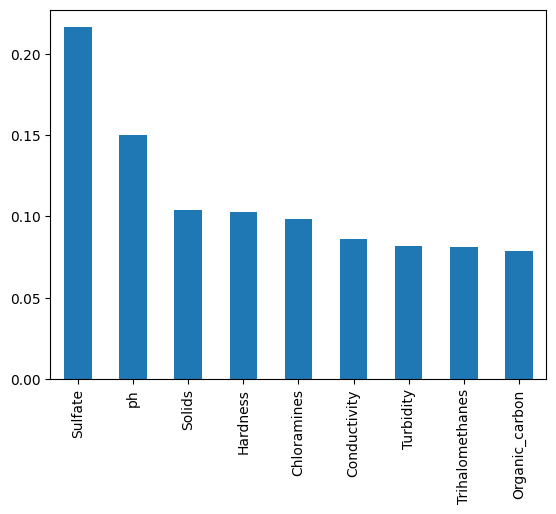

In [49]:
rf_final_w50.feature_importances_
feat_importance = pd.Series(rf_final_w50.feature_importances_, index=water.iloc[:,0:9].columns)
feat_importance.nlargest(9).plot(kind='bar')

As can be seen from the graph, the most important variable in the random forest is the *Sulfate*, whereas the variable *Organic_carbonic* has the least weight.

In [23]:
#Computing the tuned model's metrics                                 
rf_final_metrics_w50 = evaluate(rf_final_w50, X_train50, y_train50, cv=True)

improvements(rf_final_metrics_w50,rf_random_metrics_w50,'Tuned Grid','Tuned Random Model')
improvements(rf_final_metrics_w50,rf_base_metrics_w50,'Tuned Grid','Base Model')

Model Performance: 

accuracy = 73.78%.
recall = 53.28%.
precision = 73.16%.
f1_score = 61.58%.

Improvements Tuned Grid Model respect Tuned Random Model:
Accuracy: 0.66 %
Recall: 1.04 %
Precision: 1.30 %
F1-Score: 1.14 %

Improvements Tuned Grid Model respect Base Model:
Accuracy: 0.74 %
Recall: 2.37 %
Precision: 0.82 %
F1-Score: 1.67 %


### **Gradient Boosting**

In boosting, the individual models are not built on completely random subsets of data and features but sequentially by putting more weight on instances with wrong predictions and high errors. The general idea behind this is that instances, which are hard to predict correctly (“difficult” cases) will be focused on during learning, so that the model learns from past mistakes. When we train each ensemble on a subset of the training set, we also call this Stochastic Gradient Boosting, which can help improve generalizability of our model.The gradient is used to minimize a loss function, similar to how Neural Nets utilize gradient descent to optimize (“learn”) weights. 

Source: [link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

In [27]:
# Training base model
gb_base_w50 = GradientBoostingClassifier( random_state = random_seed)
print('Parameters currently in use:\n')
pprint(gb_base_w50.get_params())
print(' ')
#Computing the base model accuracy
gb_base_metrics_w50= evaluate(gb_base_w50,X_train50,y_train50,cv=True,k_fold=5)

Parameters currently in use:

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}
 
Model Performance: 

accuracy = 71.84%.
recall = 46.45%.
precision = 72.54%.
f1_score = 56.62%.


#### Random Search w/ Cross Validation

In [28]:
#Defining Random Forest Claasifier
gb = GradientBoostingClassifier(random_state = random_seed)
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(gb.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [29]:
# Create the random grid
params_grid = {
    'loss': ['log_loss','exponential'],                                   # The loss function to be optimized.
    'learning_rate':[0.001,0.01,0.1],                                     # Learning rate shrinks the contribution of each tree by learning_rate
    'n_estimators': [int(x) for x in np.linspace( 200, 500, num = 10)],   # Number of trees in random forest
    'max_features': ['sqrt','log2',None],                                 # Number of features to consider at every split
    'max_depth':  [int(x) for x in np.linspace(10, 30, num = 11)]+[None], # Maximum number of levels in tree
    'min_samples_split': [2, 5, 10],                                      # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],                                        # Minimum number of samples required at each leaf node
    'criterion':['friedman_mse','squared_error']                          # Metrics  to measure the quality of a split.
    }

gb_random_search_w50 = RandomizedSearchCV(
    estimator = gb, 
    param_distributions = params_grid,
    n_iter = 100, 
    cv = 3, 
    verbose=3, 
    random_state=random_seed, 
    n_jobs = -1)

gb_random_search_w50.fit(X_train50, y_train50)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error'],
                                        'learning_rate': [0.001, 0.01, 0.1],
                                        'loss': ['log_loss', 'exponential'],
                                        'max_depth': [10, 12, 14, 16, 18, 20,
                                                      22, 24, 26, 28, 30,
                                                      None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 233, 266, 300,
                                                         333, 366, 400, 433,
                                                         466, 500]},
                   random_state=42, verbose=3)

Actually if we used all the possible combinations we should train the Gradient Boosting 103000 times without considering the cross validation for each combinations, that would require a computational time too high, for this reason initially we will use the random search using only 100 random combinations among those available

##### Store and load Models
To avoid  traininig each time the models we will save after every training of the models the results inside *Models folder* using pickle library

In [32]:
#Saving
#pickle.dump(gb_random_search_w50.best_params_, open('Models50/Gradient_Boosting_rs_w50.pkl', 'wb'))
#Loading
gb_params_best_random_w50=pickle.load(open('Models50/Gradient_Boosting_rs_w50.pkl', 'rb'))
gb_params_best_random_w50

{'n_estimators': 433,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 10,
 'loss': 'log_loss',
 'learning_rate': 0.1,
 'criterion': 'friedman_mse'}

#### Comparing base model with tuned model with Random Search
To check if we are going in right direction we will compare the base model without tuning of parameters with the tuned model, comparing the accuracy of both models on validation set

In [36]:
# Training tuned model
gb_random_w50 =  GradientBoostingClassifier(
    loss='log_loss',
    max_depth=10,
    max_features='log2',
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=433,
    learning_rate=0.1,
    criterion='friedman_mse',
    random_state=random_seed)

In [37]:
#Computing the tuned model's metrics                                 
gb_random_metrics_w50 = evaluate(gb_random_w50, X_train50, y_train50,cv=True)

improvements(gb_random_metrics_w50,gb_base_metrics_w50,'Tuned','Base Model')

Model Performance: 

accuracy = 72.43%.
recall = 53.00%.
precision = 70.09%.
f1_score = 60.29%.

Improvements Tuned Model respect Base Model:
Accuracy: 0.83 %
Recall: 14.11 %
Precision: -3.38 %
F1-Score: 6.48 %


#### Grid Search w/ Cross Validation
Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define. To use Grid Search, we make another grid based on the best values provided by random search:

In [38]:
gb_params_best_random_w50

{'n_estimators': 433,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 10,
 'loss': 'log_loss',
 'learning_rate': 0.1,
 'criterion': 'friedman_mse'}

In [39]:
# Create the parameter grid based on the results of random search 
params_grid = {
    'loss': ['log_loss'],
    'learning_rate': [0.1],
    'criterion':['friedman_mse'],
    'max_depth': [5,10,15],
    'max_features': ['log2'],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [4,5,6],
    'n_estimators': [370,430,480]
}
# Instantiate the grid search model
gb_grid_search_w50 = GridSearchCV(
    estimator = gb, 
    param_grid = params_grid, 
    cv = 5, 
    n_jobs = -1, 
    verbose = 3)

gb_grid_search_w50.fit(X_train50, y_train50)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['friedman_mse'], 'learning_rate': [0.1],
                         'loss': ['log_loss'], 'max_depth': [5, 10, 15],
                         'max_features': ['log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [4, 5, 6],
                         'n_estimators': [370, 430, 480]},
             verbose=3)

##### Store and load Models

In [42]:
#Saving
#pickle.dump(gb_grid_search_w50.best_params_, open('Models50/Gradient_Boosting_gs_w50.pkl', 'wb'))
#Loading
gb_params_best_grid_w50=pickle.load(open('Models50/Gradient_Boosting_gs_w50.pkl', 'rb'))
gb_params_best_grid_w50

{'criterion': 'friedman_mse',
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 430}

#### Comparing tuned models 
To check if we are going in right direction we will compare the base model without tuning of parameters with the tuned model comparing the accuracy of both models on validation set

In [43]:
# Training tuned model
gb_final_w50 =  GradientBoostingClassifier(
    loss='log_loss',
    max_depth=10,
    max_features='log2',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=430,
    learning_rate=0.1,
    criterion='friedman_mse',
    random_state=random_seed)

gb_final_w50.fit(X_train50,y_train50)

GradientBoostingClassifier(max_depth=10, max_features='log2',
                           min_samples_leaf=2, min_samples_split=5,
                           n_estimators=430, random_state=42)

In [44]:
#Computing the tuned model's metrics                                 
gb_final_metrics_w50 = evaluate(gb_final_w50, X_train50, y_train50,cv=True)

improvements(gb_final_metrics_w50,gb_random_metrics_w50,'Tuned Grid','Tuned Random Model')
improvements(gb_final_metrics_w50,gb_base_metrics_w50,'Tuned Grid','Base Model')

Model Performance: 

accuracy = 74.00%.
recall = 55.46%.
precision = 72.33%.
f1_score = 62.74%.

Improvements Tuned Grid Model respect Tuned Random Model:
Accuracy: 2.16 %
Recall: 4.65 %
Precision: 3.20 %
F1-Score: 4.07 %

Improvements Tuned Grid Model respect Base Model:
Accuracy: 3.01 %
Recall: 19.41 %
Precision: -0.29 %
F1-Score: 10.82 %


### **Support Vector Machines (SVM)**

A Support Vector Machine (SVM) is a very powerful and versatile Machine Learning model, capable of performing linear or nonlinear classification, regression, and even outlier detection. SVMs are particularly well suited for classification of complex but small- or medium-sized datasets. 

source: [link](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

In [47]:
# Defining base model
svc_base = SVC(random_state= random_seed)
print('Parameters currently in use: \n')
pprint(svc_base.get_params())
print('')

# Computing the base model's metrics
svc_base_metrics = evaluate(svc_base, features = X_train50, labels = y_train50, cv=True)

Parameters currently in use: 

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

Model Performance: 

accuracy = 67.14%.
recall = 28.96%.
precision = 71.57%.
f1_score = 41.07%.


#### Grid Search w/ Cross Validation

In [ ]:
params_grid = {
    'C': [0.5, 1, 10, 20],
    'gamma': [1, 0.1, 0.01, 'scale', 'auto'],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree' : [2,3]
    }

svc_gs_w50 = GridSearchCV(
    estimator = SVC(random_state=random_seed),
    param_grid = params_grid,
    cv = 3, 
    verbose = 3,
    n_jobs = -1
)

svc_gs_w50.fit(X_train50, y_train50)

##### Save and load the model

In [6]:
#pickle.dump(svc_gs_w50, open('Models50/svc_gs_w50.pkl', 'wb'))
svc_gs_w50 = pickle.load(open('Models50/svc_gs_w50.pkl', 'rb'))
svc_gs_w50.best_params_

{'C': 1, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}

#### Compare the model with the tuned one

In [45]:
# Defining the tuned model
svc_final_w50 = SVC(
 C = 1,
 degree= 2,
 gamma= 0.1,
 kernel= 'rbf',
 random_state= random_seed
)
svc_final_w50.fit(X_train50,y_train50)

SVC(C=1, degree=2, gamma=0.1, random_state=42)

In [46]:
# Computing the tuned model accuracy                                 
svc_grid_metrics = evaluate(svc_final_w50, X_train50, y_train50, cv=True)


improvements(svc_grid_metrics,svc_base_metrics,'final','base model')

Model Performance: 

accuracy = 66.86%.
recall = 27.46%.
precision = 72.05%.
f1_score = 39.62%.

Improvements final Model respect base model:
Accuracy: -0.40 %
Recall: -5.20 %
Precision: 0.66 %
F1-Score: -3.53 %


We see that the search for the best parameter configuration using Grid Search, i.e. that exhaustive search over all possible combinations in the grid defined by the parameter ranges, did not bring any improvement in terms of accuracy percentage over the basic model.

### **K-Nearest Neighbors (KNN)**

The k-nearest neighbors algorithm, also known as KNN or k-NN, is a non-parametric, supervised learning classifier, which uses proximity to make classifications or predictions about the grouping of an individual data point. While it can be used for either regression or classification problems, it is typically used as a classification algorithm, working off the assumption that similar points can be found near one another.

In [9]:
# Defining base model
knn_base = KNeighborsClassifier()
print('Parameters currently in use: \n')
pprint(knn_base.get_params())
print('')

# Computing the base model's metrics
knn_base_metrics = evaluate(knn_base, features = X_train50, labels = y_train50, cv=True)

Parameters currently in use: 

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

Model Performance: 

accuracy = 62.27%.
recall = 39.08%.
precision = 53.03%.
f1_score = 44.94%.


#### Grid Search w/ Cross Validation

In [ ]:
params_grid = {
    'n_neighbors': [x for x in range(3,30)],
    'weights' : ['uniform', 'distance'],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p' : [2,3,4],
    'leaf_size' : [int(x) for x in np.linspace(start= 5, stop= 50, num = 10)]
    }

knn_gs_w50 = GridSearchCV(
    estimator = KNeighborsClassifier(),
    param_grid = params_grid,
    cv = 3, 
    verbose = 3,
    n_jobs = -1
)

knn_gs_w50.fit(X_train50, y_train50)

##### Save and load the model

In [11]:
#pickle.dump(knn_gs_w50, open('Models50/knn_gs_w50.pkl', 'wb'))
knn_gs_w50 = pickle.load(open('Models50/knn_gs_w50.pkl', 'rb'))
knn_gs_w50.best_params_

{'algorithm': 'auto',
 'leaf_size': 5,
 'n_neighbors': 29,
 'p': 2,
 'weights': 'distance'}

#### Compare model with the tuned model

In [12]:
knn_final_w50 = KNeighborsClassifier(
    algorithm='auto',
    leaf_size=5,
    n_neighbors=29,
    p=2,
    weights='distance'
)
knn_final_w50.fit(X_train50,y_train50)

KNeighborsClassifier(leaf_size=5, n_neighbors=29, weights='distance')

In [13]:
#Computing the tuned model accuracy                                 
knn_grid_metrics = evaluate(knn_final_w50, X_train50, y_train50, cv=True)

improvements(knn_grid_metrics,knn_base_metrics,'final','base model')

Model Performance: 

accuracy = 64.00%.
recall = 20.36%.
precision = 64.65%.
f1_score = 30.87%.

Improvements final Model respect base model:
Accuracy: 2.78 %
Recall: -47.91 %
Precision: 21.92 %
F1-Score: -31.31 %


We see that the search for the best parameter configuration using Grid Search, i.e. that exhaustive search over all possible combinations in the grid defined by the parameter intervals, led to an improvement in percentage terms of 2.78% over the basic model.

### **Models Evaluation**
Here we will choose the best model that better performs on test set using a comparing table where are reported the metrics obtained

In [47]:
rf_metrics_test_w50 = evaluate(rf_final_w50, X_test50, y_test50)

Model Performance: 

accuracy = 75.44%.
recall = 57.19%.
precision = 73.22%.
f1_score = 64.22%.


In [48]:
gb_metrics_test_w50 = evaluate(gb_final_w50, X_test50, y_test50)

Model Performance: 

accuracy = 75.19%.
recall = 58.17%.
precision = 72.06%.
f1_score = 64.38%.


In [52]:
svc_metrics_test_w50 = evaluate(svc_final_w50, X_test50, y_test50)

Model Performance: 

accuracy = 68.26%.
recall = 32.35%.
precision = 68.75%.
f1_score = 44.00%.


In [55]:
knn_metrics_test_w50 = evaluate(knn_final_w50, X_test50, y_test50)

Model Performance: 

accuracy = 66.12%.
recall = 24.51%.
precision = 66.37%.
f1_score = 35.80%.


#### **Comparison table**

| **Models**        | **Accuracy** | **Recall** | **Precision** | **F1-Score** |
|-------------------|--------------|------------|---------------|--------------|
| **Random Forest** | **75.44%**   | **57.19%** | **73.22%**    | **64.22%**   |
| Gradient Boosting | 75.19%       | 58.17%     | 72.06%        | 64.38%       |
| SVC               | 68.26%       | 32.35%     | 68.75%        | 44.00%       |
| K-NN              | 66.12%       | 24.51%     | 66.37%        | 35.80%       |

Looking at the table, the model that reported the best performance on test set is the **Random Forest**, even if the Gradient Boosting has reported a better recall.
Below we will show the confusion matrix of the Random Forest model on test set


Confusion matrix: 


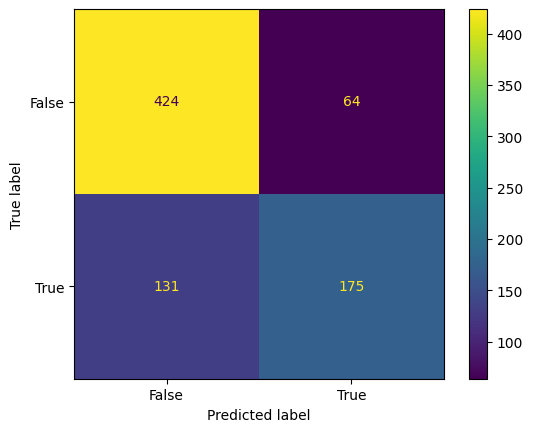

Model Performance: 

accuracy = 75.44%.
recall = 57.19%.
precision = 73.22%.
f1_score = 64.22%.


In [24]:
rf_metrics_test_w50 = evaluate(rf_final_w50, X_test50, y_test50,conf_matrix=True)

## **Unsupervised models**

Unsupervised learning, also known as unsupervised machine learning, uses machine learning algorithms to analyze and cluster unlabeled datasets. These algorithms discover hidden patterns or data groupings without the need for human intervention. Its ability to discover similarities and differences in information make it the ideal solution for exploratory data analysis, cross-selling strategies, customer segmentation, and image recognition.There are two main unsupervised learning problems: 

- **Clustering**. Clustering analysis is a grouping effort in which the members of a group (i.e., a cluster) are more similar to each other than the members of the other clusters. There are many different clustering methods available. They usually utilize a type of similarity measure based on selected metrics such as Euclidean or probabilistic distance. Bioinformatic sequence analysis, genetic clustering, pattern mining, and object recognition are some of the clustering problems that may be tackled with the unsupervised learning approach.

- **Dimensionality Reduction**. Another use case of unsupervised learning is dimensionality reduction. Dimensionality is equivalent to the number of features used in a dataset. In some datasets, you may find hundreds of potential features stored in individual columns. In most of these datasets, several of these columns are highly correlated. Therefore, we should either select the best ones, i.e., feature selection, or extract new features combining the existing ones, i.e., feature extraction. This is where unsupervised learning comes into play. Dimensionality reduction methods help us create neater and cleaner models that are free of noise and unnecessary features.


In [29]:
df_w50 = pd.DataFrame(water50, columns = water.columns)
y_w50=df_w50['Potability']
df_w50=df_w50.drop(columns='Potability')

### Dimensionality Reduction models
The Dimensionality Reduction models that we chose are the following:
- **PCA**
- **Tranked SVD**

#### **Principal Component Analysis**
Principal component analysis (PCA) is a popular technique for analyzing large datasets containing a high number of dimensions/features per observation, increasing the interpretability of data while preserving the maximum amount of information, and enabling the visualization of multidimensional data. 

PCA is particularly useful when the available variables are highly correlated.Correlation indicates that there is redundancy1 in the data. Due to this redundancy,
PCA can be used to reduce the original variables into a smaller number of new variables (i.e. the PCs) explaining most of the variance in the original variables.

Source: [link](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA)

In [36]:
# Applying PCA function 
pca = PCA(n_components = 9)
df_w50_pca = pca.fit_transform(df_w50)

explained_variance_w50 = pca.explained_variance_ratio_

In [37]:
pca_df_w50 = pd.DataFrame(data = df_w50_pca,
                           columns = ['PC1', 'PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9']
                          )

In [38]:
print('Explained variation per principal component: {}'.format(explained_variance_w50))

Explained variation per principal component: [0.13440689 0.12800666 0.11648738 0.11261846 0.11004933 0.10825728
 0.10473145 0.09809888 0.08734367]


Let'see how much variability explain the first 2 PCs

In [39]:
sum(explained_variance_w50[0:2])

0.26241354972220104

To explain to 80% of variability we need 7 PCs over 9, this means that the variables are enough independent each others

In [40]:
sum(explained_variance_w50[0:7])

0.8145574516790435

<Figure size 640x480 with 0 Axes>

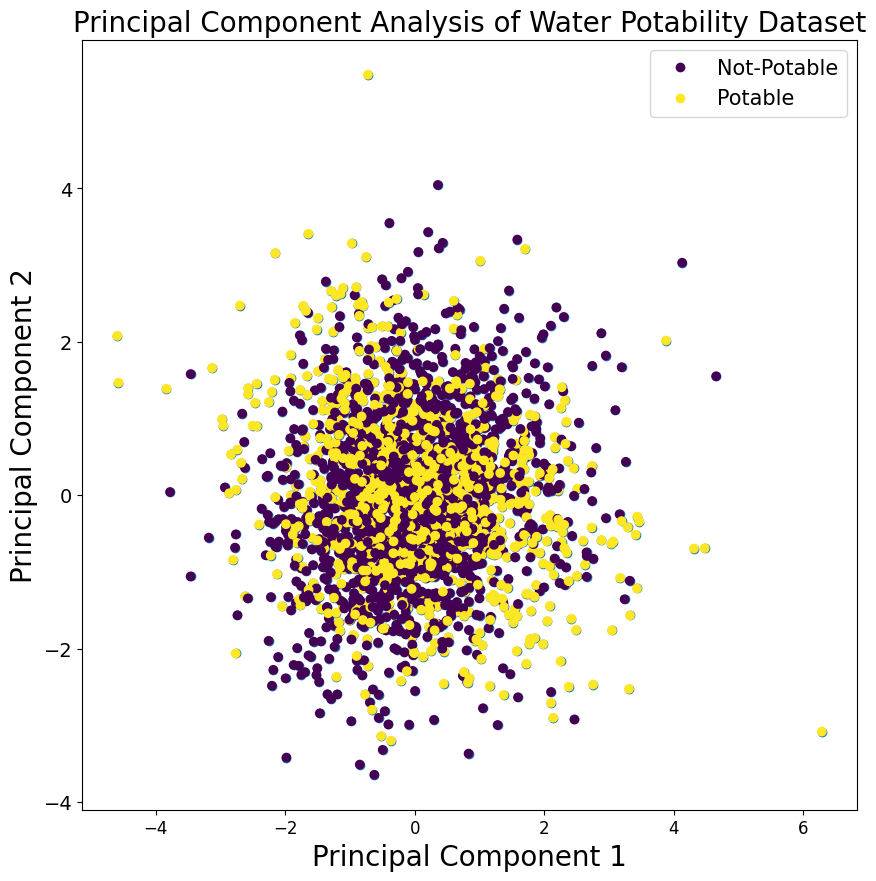

In [ ]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component 1',fontsize=20)
plt.ylabel('Principal Component 2',fontsize=20)
plt.scatter(x=pca_df_w50['PC1'],y=pca_df_w50['PC2'])
plt.title("Principal Component Analysis of Water Potability Dataset",fontsize=20)


plot=plt.scatter(x=pca_df_w50[ 'PC1'],
            y=pca_df_w50[ 'PC2'], 
            c = y_w50)

plt.legend(plot.legend_elements()[0], ['Not-Potable','Potable'],prop={'size': 15})
plt.show()

#### **Truncated SVD**

The singular-value decomposition (SVD) is a dimension reduction technique for matrices that reduces the matrix into its component to simplify the calculation. There are many kinds of SVD methods:
- Truncated SVD 
- Partial least square SVD 
- Randomized SVD

In this part, Truncated SVD will be applied.

source: [link](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD)

It is a matrix factorization technique similar to PCA (principal component analysis). However, we perform Truncated SVD  or any SVD on the data matrix, whereas we use PCA on the covariance matrix. Truncated SVD factorized data matrix where the number of columns is equal to the truncation. Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with sparse matrices efficiently. It drops the digits after the decimal place for shorting the value of float digits mathematically.  A given m⤫n matrix truncated SVD will produce matrices with the specified number of columns, whereas a normal SVD procedure will produce with m columns. It means that it will drop off all features except the number of features provided to it. 

In [41]:
svd = TruncatedSVD(n_components=9, n_iter=7, random_state= random_seed)
df_w50_svd = svd.fit_transform(df_w50)

explained_variance_svd = svd.explained_variance_ratio_

In [42]:
svd_df_w50 = pd.DataFrame(data = df_w50_svd,
                           columns = ['PC1', 'PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9']
                          )

In [43]:
print('Explained variation per principal component: {}'.format(explained_variance_svd))
print('\nSingular values computed by Truncated SVD: ', svd.singular_values_)

Explained variation per principal component: [0.13440689 0.12800666 0.11648738 0.11261846 0.11004933 0.10825728
 0.10473145 0.09809888 0.08734367]

Singular values computed by Truncated SVD:  [56.55392374 55.19100053 52.64915722 51.7674504  51.17356596 50.75519857
 49.92183469 48.31522381 45.5898018 ]


In [44]:
sum(explained_variance_svd[0:2])

0.2624135497222013

In [34]:
sum(explained_variance_svd[0:7])

0.8145574516790439

To explain to 80% of variability we need 7 PCs over 9, this means that the variables are enough independent each others

### Clustering models
The Clustering models that we chose are the following:
- **K-Means**
- **DBSCAN**


#### **K-Means**
K-means is one of the most widely used and best performing clustering algorithms. Despite this, it is a very simple algorithm to implement and use.

K-means is based on so-called centroids. The centroid is a point belonging to the feature space that averages the distances between all the data belonging to the cluster associated with it. It thus represents a kind of barycenter of the cluster and in general, precisely because of its characteristics, is not one of the points in the dataset.

Source: [link](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

Text(0, 0.5, 'Sum Squared Distance')

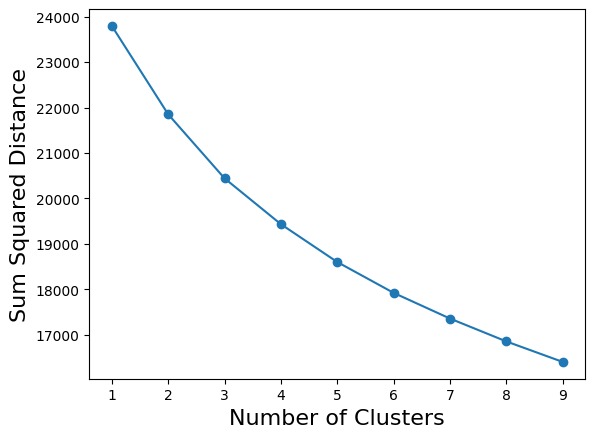

In [ ]:
#To check the optimal possible number of clusters we will use elbow method
sdq = {}
for k in range(1, 10):
                # n_init is the number of times the k-means algorithm is run with different centroid seeds
    km = KMeans(n_init="auto",
                # Init random assign the centroids randomly
                init="random", 
                # n_clusters define the number of clusters to research at each iteration
                n_clusters=k
                )

    km.fit(df_w50)
    # Inertia contains Sum of squared distances of samples to their closest cluster center,
    #  weighted by the sample weights if provided.
    sdq[k] = km.inertia_

# Plotting the results
plt.plot(list(sdq.keys()), list(sdq.values()), marker="o")
plt.xlabel("Number of Clusters", fontsize=16)
plt.ylabel("Sum Squared Distance", fontsize=16)

As we can see it doesn't seem to be the presence of clusters, since is not present a clear elbow in the chart

#### **DBSCAN**
Density-based spatial clustering of applications with noise (DBSCAN) is a data clustering algorithm proposed by Martin Ester, Hans-Peter Kriegel, Jörg Sander and Xiaowei Xu in 1996. It is a density-based clustering non-parametric algorithm: given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions (whose nearest neighbors are too far away). DBSCAN is one of the most common clustering algorithms and also most cited in scientific literature.

Source: [link](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

In [ ]:
db = DBSCAN(eps=0.3, min_samples=10).fit(df_w50)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 0
Estimated number of noise points: 2644


## Conclusion

As we have seen, the unsupervised approach did not lead to any relevant results. In particular, dimensionality reduction techniques, such as Principal Component Analysis and Singular Value Decomposition, confirmed the impossibility of being able to reduce the number of variables without a loss of information. This was probably due to the fact that both techniques perform best when the variables are highly correlated. In fact, during the expolarization of the data, no correlation between the variables emerged. Similarly, during the cluster analysis phase, no clusters emerged between the observations.

Quite different were the results of the supervised part. Undoubtedly, the ensemble methods were the ones that obtained good metrics. Indeed, while support vector mechines and k-nearest neighbours had obvious difficulties in distinguishing the two classes of the target variable, random forest and gradiend boosting succeeded in the arduous task of overcoming this difficulty.

Of these, the best model was random forest, achieving an accuracy of 75.44% on the test set.

By comparing these results with those obtained using the dataset which, instead of eliminating a certain percentage of observations having at least one component with a missing value, input these values with a statistically significant value, we can conclude that for this type of dataset, the reduction of observations results in a loss of performance for the models.